In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import matplotlib.cm as cm
import networkx.algorithms.community as nxcom
from community import community_louvain
import ipdb

In [2]:
seg = pd.read_csv('./data/segement.csv', header=None)

In [3]:
raw0 = pd.read_csv(open('./data/id2000.csv'), header=0, index_col=0)
q = pd.read_csv('./data/q_20_aggragated.csv', index_col = 0)
b = pd.read_csv('./data/b_20_aggragated.csv', index_col = 0)  # time occupancy, (density)
raw0

,id2,lat,long,id,num_road,class
0,2001,116.42769,39.94485,HI7000d,4,0
1,2002,116.42764,39.94330,HI7001a,3,0
2,2003,116.42782,39.93705,HI7002a,2,0
3,2005,116.42832,39.92993,HI7039a,3,0
4,2006,116.42785,39.92513,HI7003a,3,0
...,...,...,...,...,...,...
202,61004,116.29400,39.97990,HI9037g,3,3
203,61005,116.29300,39.98990,HI9097c,3,3
204,61006,116.29000,39.99350,HI9098c,3,3
205,61007,116.28600,39.99870,HI9099c,3,3


In [4]:
q_det = q.T.mean()
b_det = b.T.mean()

In [5]:
nodes = np.array(raw0['id2'])

relation_df = pd.read_csv('./data/edges_all.csv', header = None)

In [6]:
relation_df['flow'] = ''

for i in range(len(relation_df)):
    #ipdb.set_trace()
    det1 = raw0[raw0['id2']==relation_df.iloc[i, 0]]['id'].iloc[0]
    det2 = raw0[raw0['id2']==relation_df.iloc[i, 1]]['id'].iloc[0]
    relation_df.iloc[i, 2] = (q_det[det1] + q_det[det2]) / 2

relation_df

,0,1,flow
0,2001,2002,467.753
1,2002,2003,346.658
2,2003,2005,290.099
3,2005,2006,394.707
4,2006,2007,431.022
...,...,...,...
235,61004,4045,398.524
236,61005,4043,439.801
237,61005,4045,375.032
238,61001,3051,263.398


In [7]:
relation = np.array(relation_df)
# relation

In [8]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(relation)

In [9]:
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 207 nodes.
We have 240 edges.


In [10]:
# plt.figure(figsize = (10,10))

# nx.draw_networkx(G)

In [11]:
pos0 = raw0.iloc[:, 1:3]
pos0 = np.array(pos0)

In [12]:
vnode = pos0
npos = dict(zip(nodes, vnode))  # 获取节点与坐标之间的映射关系，用字典表示
 # 若显示多个图，可将所有节点放入该列表中
# pos = {} 
# pos.update(npos)
# nlabels = dict(zip(nodes, nodes))  # 标志字典，构建节点与标识点之间的关系


In [13]:
# relation.reshape()

In [14]:
# G.edges()

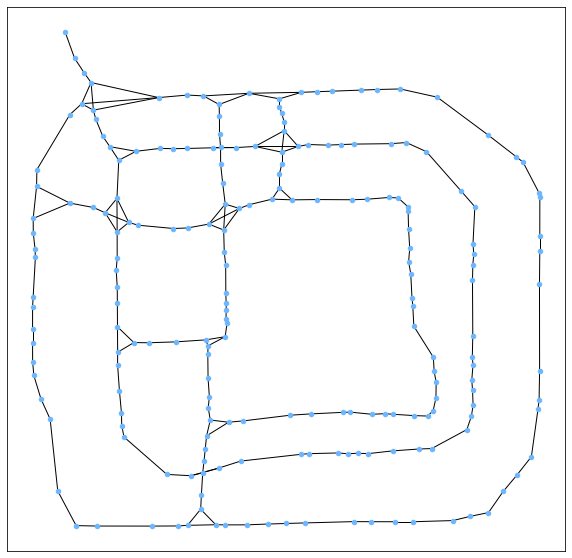

In [15]:
plt.figure(figsize = (10,10))

nx.draw_networkx(G, pos = npos, node_size=20, node_color="#6CB6FF", with_labels=False)
plt.show()

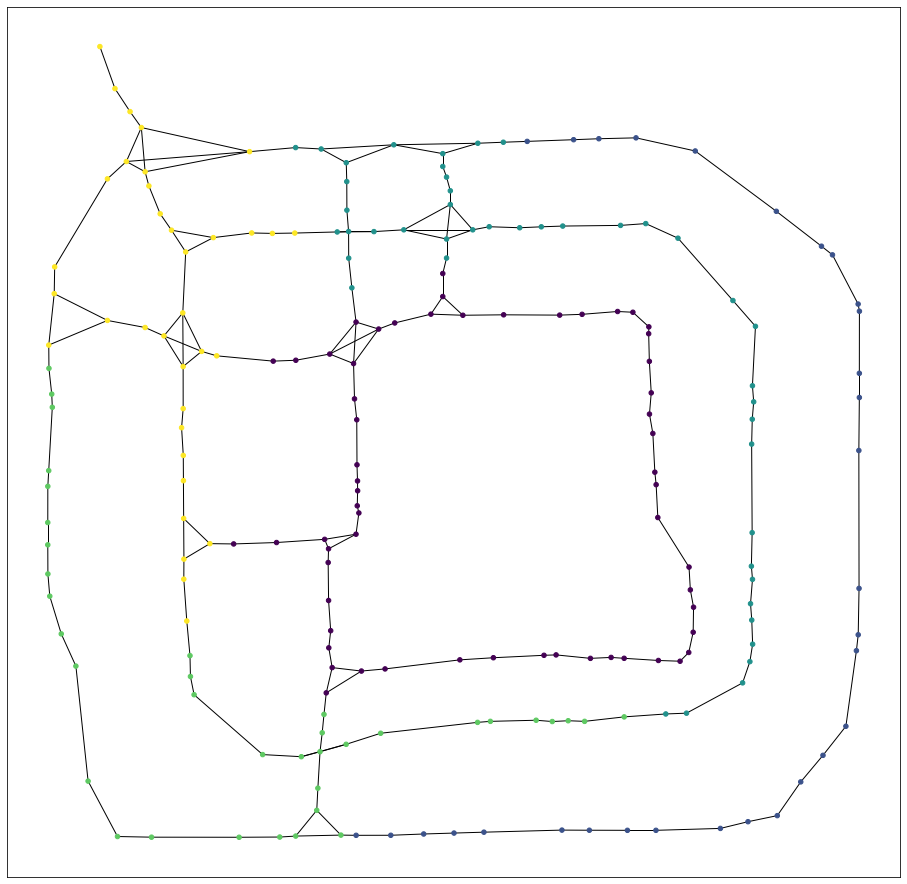

In [16]:
partition = community_louvain.best_partition(G, resolution=10, weight='weight', random_state=8)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

plt.figure(figsize = (16,16))
nx.draw_networkx(G, pos = npos, node_size=20, node_color=list(partition.values()), with_labels=False)
plt.show()

In [17]:
partition_results = pd.DataFrame(data = list(partition.values()))

In [18]:
partition_results['node'] = nodes


In [19]:
partition_results

,0,node
0,0,2001
1,0,2002
2,0,2003
3,0,2005
4,0,2006
...,...,...
202,4,61004
203,4,61005
204,4,61006
205,4,61007


In [20]:
partition_results.to_csv('./res/partition_results1.csv', index=False)

In [21]:
relation_df['if boundary nodes'] = ''

for i in range(len(relation_df)):
    class1 = partition_results[partition_results['node']==relation_df.iloc[i, 0]].iloc[0, 0]
    class2 = partition_results[partition_results['node']==relation_df.iloc[i, 1]].iloc[0, 0]
    if class1 != class2:
        relation_df.iloc[i, 3] = 1
    else:
        relation_df.iloc[i, 3] = 0

In [22]:
bound_nodes_df = relation_df[relation_df['if boundary nodes']==1].iloc[:, 0:2]
bound_nodes = np.array(bound_nodes_df).flatten()

In [23]:
bound_dets_df = pd.DataFrame([], columns=['n1d1','n1d2','n2d1','n2d2'], index=range(len(bound_nodes_df)))
for i in range(len(bound_nodes_df)):
    node1 = bound_nodes_df.iloc[i, 0]
    node2 = bound_nodes_df.iloc[i, 1]
    bound_dets_df.iloc[i, 0] = seg[seg[0]==node1].iloc[0, 6]
    bound_dets_df.iloc[i, 1] = seg[seg[0]==node1].iloc[0, 7]
    bound_dets_df.iloc[i, 2] = seg[seg[0]==node2].iloc[0, 6]
    bound_dets_df.iloc[i, 3] = seg[seg[0]==node2].iloc[0, 7]

In [24]:
bound_dets_df

,n1d1,n1d2,n2d1,n2d2
0,HI8011a,HI8057d,HI8058b,HI8012d
1,HI8023c,HI8073a,HI8025c,HI8024a
2,HI8038d,HI8037b,HI8039d,HI8066b
3,HI9018d,HI9019b,HI9019d,HI9020b
4,HI9071a,HI9033c,HI9033a,HI9034c
5,HI9038d,HI9073b,HI9039d,HI9038b
6,HI9043d,HI9042b,HI9044d,HI9043b
7,HI9057a,HI9077c,HI9077a,HI7022c
8,HI9060b,HI9059d,HI8062b,HI9060d
9,HI9061c,HI7032a,HI9062c,HI9061a


In [25]:
b_det = pd.DataFrame(b_det)
b_det['det'] = b_det.index
b_det['node']=''
b_det.index=range(402)

for i in range(len(b_det)):
    try:
        b_det.iloc[i, 2] = seg[seg[6]==b_det.iloc[i, 1]].iloc[0, 0]
    except:
        b_det.iloc[i, 2] = seg[seg[7]==b_det.iloc[i, 1]].iloc[0, 0]

b_det['class'] = ''
for i in range(len(b_det)):
    b_det.iloc[i, 3] = partition_results[partition_results['node']==b_det.iloc[i, 2]].iloc[0, 0]

In [26]:
b_det

,0,det,node,class
0,13.016764,HI2063a,3044,4
1,19.076875,HI2063c,3043,4
2,4.800302,HI2065a,3046,4
3,13.778998,HI2065c,3044,4
4,5.571532,HI2068a,2043,0
...,...,...,...,...
397,7.279762,HI9099c,61007,4
398,10.456748,HI9100a,61009,4
399,10.709316,HI9101c,61009,4
400,7.264045,HI9102a,61004,4


In [27]:
for i in range(len(bound_nodes_df)):
    node1 = bound_nodes_df.iloc[i, 0]
    node2 = bound_nodes_df.iloc[i, 1]
    class1 = partition_results[partition_results['node']==node1].iloc[0, 0]
    class2 = partition_results[partition_results['node']==node2].iloc[0, 0]
    
    b1 = np.array(b_det[b_det['class']==class1][0])
    b2 = np.array(b_det[b_det['class']==class2][0])
    
    ini_var1 = np.var(b1)  # initial variance 1
    ini_var2 = np.var(b2)
    ini_mean1 = np.mean(b1)
    ini_mean2 = np.mean(b2)
    
    # 把node1从class1里面挑出来
    # 计算class1的variance
    # 把node1加到class2
    # 计算class2的variance
    # 比较两个variance，假如varianc减小，则保留更改，反之恢复原位
    # 对node2重复以上五步

In [28]:
b_det[b_det['class']==class1]

,0,det,node,class
4,5.571532,HI2068a,2043,0
5,21.091435,HI2068c,2041,0
6,0.799476,HI2068d,21001,0
9,9.070899,HI2075a,2045,0
10,13.042795,HI2075c,2044,0
...,...,...,...,...
372,39.568489,HI9082c,51002,0
381,1.748385,HI9088d,41002,0
382,6.350064,HI9090b,41002,0
383,1.785459,HI9090d,41003,0


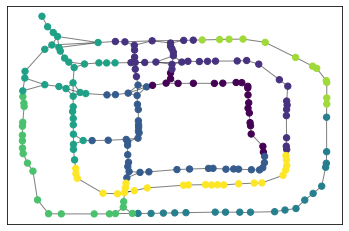

In [29]:
# compute the best partition
partition = community_louvain.best_partition(G, resolution=6, random_state=1)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, npos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, npos, relation, alpha=0.5)
plt.show()